# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi
#import lal
#import lalsimulation as lalsim
import pesummary
from pesummary.io import read
import json
import os.path

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

### Functions for injection values, Bayes factors, evidences, etc

In [52]:
# LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
#              'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$ [mpc]", \
#             'dec' : 'dec', 'ra' : 'ra', 'theta_jn' : r"$\theta_{jn}$", 'tilt_1' : r"$\theta_1$", \
#             'tilt_2' : r"$\theta_2$", 'psi' : r"$\psi$", 'phase' : r'$\Delta \phi$', 'chi_eff' : r'$\chi_\mathrm{eff}$', \
#             'm_1' : r"$m_1$", 'm_2' : r"$m_2$"}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['total_mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    TruthDict['m_1'] = params['m_1']
    TruthDict['m_2'] = params['m_2']
    TruthDict['chi_eff'] = params['chi_eff']
    TruthDict['chi_p'] = 0.0 ## Since this is a non-precessing run
    f.close()
    return TruthDict

def GetEvidences(p):
    """ Generate a .dat file for the evidences if it doesn't exist, 
        reading from the json file.
        Returns log_evidence log_evidence_err log_noise_evidence log_bayes_factor """
    
    name = p + "/evidences.dat"
 
    if not os.path.isfile(name):
        
        print("Generating evidences.dat from result.json file")
        
        f_res = open(p + '/fast_tutorial_result.json')
        data = json.load(f_res)
        f_res.close()
      
        f_out = open(name, 'w')
        f_out.write("# log_evidence log_evidence_err log_noise_evidence log_bayes_factor \n")
        f_out.write("%f %f %f %f" % (data['log_evidence'], data['log_evidence_err'], data['log_noise_evidence'], data['log_bayes_factor']))
        f_out.close()

    return np.loadtxt(name, comments="#",usecols=([0,1,2,3]),unpack=True) 

def EllinKm(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value

def Ell_SNR_String(ell_string, mass, snr):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    string = "%.f km, " % (phys_ell_km.value) + snr
    return string

def SummaryPageFile(name):
    return "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/" + name + \
        "/summary_pages/samples/posterior_samples.h5"

RangeDict = {'mass_ratio': (0.6, 1.0), 'total_mass' : (65.0, 71.0), 'chi_eff' : (-0.1, 0.1), 'chi_p' : (0.0, 1.0), 'luminosity_distance' : (200, 700)}

In [51]:
## Grab the mass
p = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/PHENOM_dCS_0p0_75'
TruthDict = GetTruthDict(p)
print(TruthDict['luminosity_distance'])
mass = TruthDict['mass']

601.0372365294345


### One dimensional histograms

mass_ratio, chirp_mass, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, dec, ra, theta_jn, psi, phase, geocent_time, log_likelihood, log_prior, redshift, comoving_distance, inverted_mass_ratio, mass_1, mass_2, total_mass, symmetric_mass_ratio, mass_1_source, mass_2_source, total_mass_source, chirp_mass_source, iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z, phi_1, phi_2, chi_p, chi_p_2spin, chi_eff, beta, psi_J, cos_tilt_1, cos_tilt_2, H1_time, L1_time, V1_time, cos_theta_jn, viewing_angle, cos_iota

In [ ]:

def Histogram(param):

    ells = ['0p0', '0p33', '0p35', '0p37']
    snrs = ['75' for ell in ells]
    #snrs = ['25', '75', '125']
    #ells = ['0p0' for snr in snrs]
    colors = sns.color_palette('gnuplot2', n_colors=len(snrs) + 1)
    
    fig = plt.figure()
    
    for ell, snr, color in zip(ells, snrs, colors):
        
        print(ell, snr)
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(param, type="hist", kde=True, color = color, label = Ell_SNR_String(ell, mass, snr), fig = fig, plot_percentile = False, title = False)
        
    plt.xlim(RangeDict[param])
    plt.legend(loc = 'upper right')
    plt.grid()
    plt.savefig('kde_' + param)
    plt.show()
    
params_avail = ["mass_ratio", "chirp_mass", "a_1", "a_2", "tilt_1", "tilt_2", \
                "phi_12", "phi_jl", "luminosity_distance", "dec", "ra", \
                "theta_jn", "psi", "phase", "geocent_time", "total_mass", \
                "symmetric_mass_ratio", "iota", "phi_1", "phi_2", "chi_p", "chi_p_2spin", \
                "chi_eff", "beta", "psi_J", "cos_tilt_1", "cos_tilt_2", "H1_time", \
                "L1_time", "V1_time", "cos_theta_jn", "viewing_angle", "cos_iota"]
Histogram("luminosity_distance")


0p0 75
0p33 75
0p35 75
0p37 75


In [56]:
base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
parameters = ['mass_ratio', 'luminosity_distance', 'total_mass', 'chi_p', 'chi_eff']
truths = [TruthDict[param] for param in parameters]
ranges = [RangeDict[param] for param in parameters]

dim = len(parameters) 
    
file_name = SummaryPageFile('PHENOM_dCS_0p0_75')
data = read(file_name)
samples_dict = data.samples_dict
posterior_samples = samples_dict["summary_pages"]
   

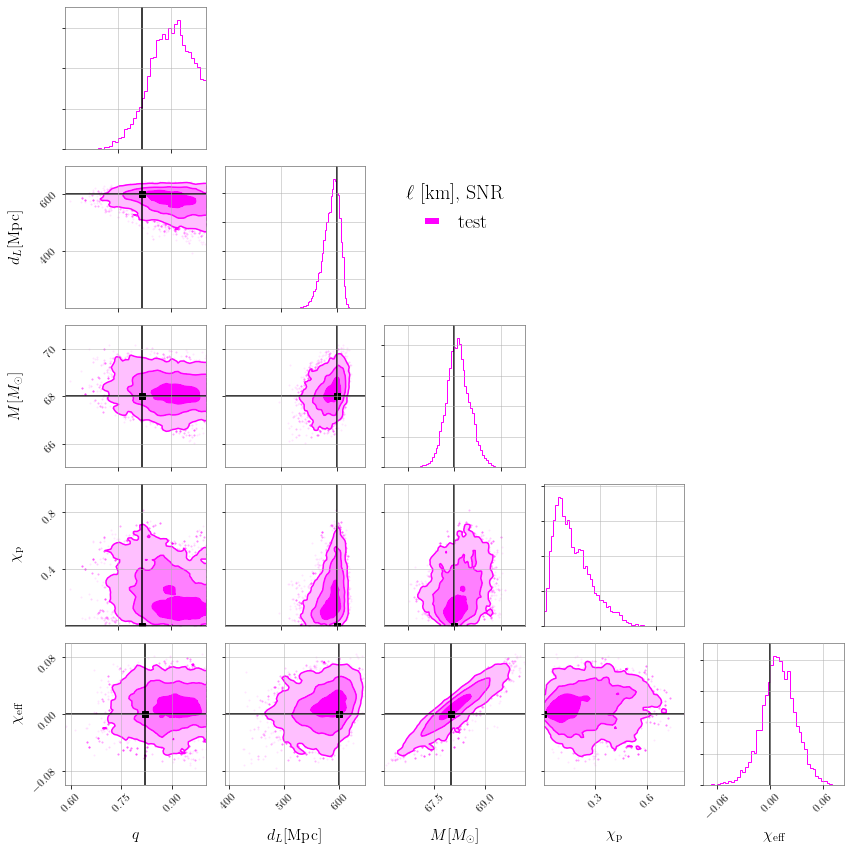

In [59]:
fig, ax_arr = plt.subplots(dim, dim, figsize=(12, 12))
handles = []
posterior_samples.plot(type="corner",
                         parameters=parameters, fig = fig, color = 'magenta', truths=truths, truth_color='black', \
                           quantiles=[], range=ranges)

l = ax_arr[1][2].plot([0,0], [0,0], label='test', color = 'magenta')
handles.append(l[0])

legend = ax_arr[1][2].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR', loc = 'upper center', fontsize=20)

for i in range(4):
    ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
    ax_arr[i][1].set_xlim(RangeDict['luminosity_distance'])
    ax_arr[i][2].set_xlim(RangeDict['total_mass'])
    ax_arr[i][3].set_xlim(RangeDict['chi_p'])
    ax_arr[i][4].set_xlim(RangeDict['chi_eff'])


ax_arr[1][0].set_ylim(RangeDict['luminosity_distance'])
ax_arr[2][0].set_ylim(RangeDict['total_mass'])
ax_arr[2][1].set_ylim(RangeDict['total_mass'])
ax_arr[3][0].set_ylim(RangeDict['chi_p'])
ax_arr[3][1].set_ylim(RangeDict['chi_p'])
ax_arr[3][2].set_ylim(RangeDict['chi_p'])
ax_arr[4][0].set_ylim(RangeDict['chi_eff'])
ax_arr[4][1].set_ylim(RangeDict['chi_eff'])
ax_arr[4][2].set_ylim(RangeDict['chi_eff'])
ax_arr[4][3].set_ylim(RangeDict['chi_eff'])

plt.setp(legend.get_title(),fontsize=20)


plt.tight_layout()
plt.show()


In [ ]:
def CornerPlot(cmap):
    """ Make a corner plot of Bilby runs on GR injections with various SNRs"""

    base = '/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/'
    parameters = ['mass_ratio', 'luminosity_distance', 'total_mass', 'chi_p', 'chi_eff']
    truths = [TruthDict[param] for param in parameters]
    ranges = [RangeDict[param] for param in parameters]
    print(ranges)
    dim = len(parameters) 

    ells = ['0p0', '0p33', '0p37']
    snrs = ['75' for ell in ells]
    colors = sns.color_palette(cmap, n_colors=len(snrs) + 1)
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(12, 12))
    handles = []
    
    for ell, snr, c in zip(ells, snrs, colors):
        
        file_name = SummaryPageFile('PHENOM_dCS_' + ell + '_' + snr)
        print(file_name)
        data = read(file_name)
        samples_dict = data.samples_dict
        posterior_samples = samples_dict["summary_pages"]
        posterior_samples.plot(type="corner",
                             parameters=parameters, fig = fig, color = c, truths=truths, truth_color='black', \
                               quantiles=[], range=ranges)
    
        ## Dealing with the legend
        l = ax_arr[0][dim-1].plot([0,0], [0,0], label=Ell_SNR_String(ell, mass, snr), color = c)
        handles.append(l[0])

    ## Plot the injected values myself
    
    legend = ax_arr[1][2].legend(handles=handles, frameon=False, title = r'$\ell$ [km], SNR', loc = 'upper center', fontsize=20)
    
    for i in range(4):
        ax_arr[i][0].set_xlim(RangeDict['mass_ratio'])
        ax_arr[i][1].set_xlim(RangeDict['luminosity_distance'])
        ax_arr[i][2].set_xlim(RangeDict['total_mass'])
        ax_arr[i][3].set_xlim(RangeDict['chi_p'])
        ax_arr[i][4].set_xlim(RangeDict['chi_eff'])
        
        
    ax_arr[1][0].set_ylim(RangeDict['luminosity_distance'])
    ax_arr[2][0].set_ylim(RangeDict['total_mass'])
    ax_arr[2][1].set_ylim(RangeDict['total_mass'])
    ax_arr[3][0].set_ylim(RangeDict['chi_p'])
    ax_arr[3][1].set_ylim(RangeDict['chi_p'])
    ax_arr[3][2].set_ylim(RangeDict['chi_p'])
    ax_arr[4][0].set_ylim(RangeDict['chi_eff'])
    ax_arr[4][1].set_ylim(RangeDict['chi_eff'])
    ax_arr[4][2].set_ylim(RangeDict['chi_eff'])
    ax_arr[4][3].set_ylim(RangeDict['chi_eff'])
    
    plt.setp(legend.get_title(),fontsize=20)
    
   
    #for ax in fig.get_axes():
    #    ax.tick_params(axis='both', labelsize=12, length=6)
    #ax_arr[0][0].set_xlim([0.7, 1.0])   
    #ax_arr[2][1].set_xlim([60, 75])   
        
    plt.tight_layout()
    plt.savefig('dCSCorner_75.pdf')
    plt.show()
    
CornerPlot('gnuplot2')  

### Plot Bayes factors as a function of SNR Bilby runs

0p0 25 297.682087
0p0 75 2949.158425
0p0 125 8279.95828
0p25 25 297.811283
0p25 75 2947.30526
0p25 125 8273.319306
0p3 25 295.263237
0p3 75 2935.553395
0p3 125 8248.99412
0p37 25 283.584561
0p37 75 2875.249547
0p37 125 8098.943613


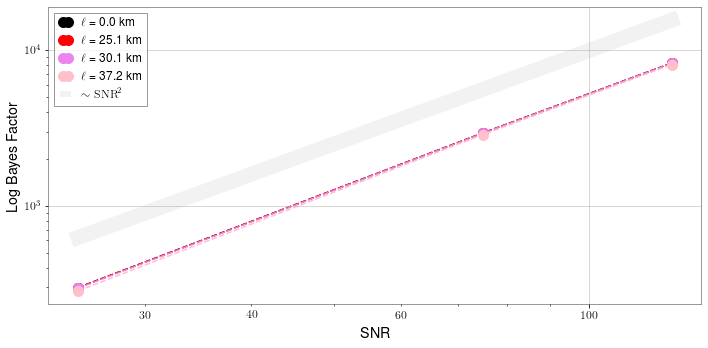

In [86]:
def PlotBayesSNR():
    """ Plot Bayes factors for various dCS parameters as a function of SNR """
    
    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68
    
    ells = ["0p0", "0p25", "0p3", "0p37"]
    colors = ['black', 'red', 'violet', 'pink', 'lightblue', 'orange']
    snrs = [25, 75, 125]
    
    plt.figure(figsize=(10, 5))
    
    for ell, color in zip(ells, colors):

        bayes_arr = []

        for snr in snrs:

            p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr)  + "/outdir_fref"
            log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
            print(ell, snr, log_bayes_factor)
            bayes_arr.append(log_bayes_factor)

        plt.plot(snrs, bayes_arr, '--o', color = color, label = "$\ell$ = %.1f km" % EllinKm(ell, mass), markersize = 10)
        
    ## Add in 1/SNR^2 curve 
    SNRS = np.linspace(snrs[0], snrs[-1], 100)
    snr_curve = SNRS**2.0
    plt.plot(SNRS, snr_curve, color='gray', label = r'$\sim \mathrm{SNR}^{2}$', alpha = 0.1, lw = 15.0)

    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Log Bayes Factor')
    plt.xlabel('SNR')
    plt.tight_layout()
    plt.savefig('BayesSNR.pdf')
    plt.show()
    
#PlotBayesSNR()

### Plot Bayes factors as a function of $\ell$ for Bilby Runs

0p0
0p25
Generating evidences.dat from result.json file
0p3
0p33
0p35
Generating evidences.dat from result.json file
0p37
[-51.028021, -54.154522, -64.237298, -83.239702, -100.283522, -117.185273]
[-3001.530233, -3001.493688, -3001.417232, -3001.327918, -3001.246504, -3001.149646]
[2950.502212, 2947.339166, 2937.179934, 2918.088216, 2900.962983, 2883.964373]


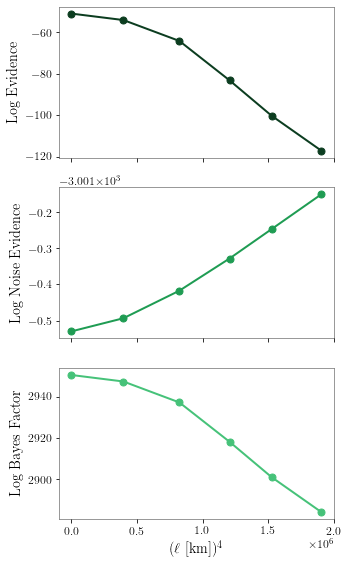

In [19]:
def PlotBayesEll():

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/BilbyPE/"
    mass = 68

    ells = ["0p0", "0p25", "0p3", "0p33", "0p35", "0p37"]
    ell_vals = [EllinKm(ell, mass) for ell in ells]
    snr = 75

    log_evidences = [] 
    log_evidence_errs = [] 
    log_noise_evidences = [] 
    log_bayes_factors = []

    for ell in ells:

        print(ell)
        p = base_dir + "PHENOM_dCS_" + ell + "_" + str(snr) + "/outdir_fref"
        log_evidence, log_evidence_err, log_noise_evidence, log_bayes_factor = GetEvidences(p)
        print(log_evidence_err)
        
        log_evidences.append(log_evidence)
        log_noise_evidences.append(log_noise_evidence)
        log_bayes_factors.append( log_bayes_factor)

    fig, axes = plt.subplots(3, figsize=(5,8), sharex = True)

    print(log_evidences)
    print(log_noise_evidences)
    print(log_bayes_factors)
    
    axes[0].plot(np.array(ell_vals)**4, log_evidences, '-o', color = '#0c3d20', markersize = 7, lw = 2.0)
    axes[1].plot(np.array(ell_vals)**4, log_noise_evidences, '-o', color = '#1f9c53', markersize = 7, lw = 2.0)
    axes[2].plot(np.array(ell_vals)**4, log_bayes_factors, '-o', color = '#46c279',  markersize = 7, lw = 2.0)

    axes[0].set_ylabel('Log Evidence')
    axes[1].set_ylabel('Log Noise Evidence')
    axes[2].set_ylabel('Log Bayes Factor')
    

    for ax in axes:
        ax.tick_params(axis='x', which='both', bottom=True, top=False) 
        ax.grid()

    plt.xlabel(r'($\ell$ [km])${}^4$')
    plt.tight_layout()
    plt.savefig('BayesEll.pdf')
    plt.show()
    
PlotBayesEll()

### Understanding Bilby minimum frequency values

Bilby parameter estimation with the surrogate model requires specifying a minimum frequency f_sur_min, and this minuimum frequency must be greater than the minimum frequency of the waveform injection. If this criterion is not met (ie we ask for a lower f_sur_min than the injection f_injection_min), then Bilby throws an error saying that the requested minimum frequency, f_bilby_requested, is < f_injection_min. However, in practice, the f_bilby_requested reported by Bilby error messages is NOT equal to f_sur_min, which doesn't make sense. However, we can explore the relationship between these two quantities using the surrogate injection below:

for configuration:

mass_ratio = 1.0
chirp_mass = 20.0
a_1 = 0.99
a_2 = 0.99
tilt_1 = 0.0
tilt_2 = 3.14159265359
phi_12 = 0.0
phi_jl = 0.0


In [10]:
def BilbyMinimumFrequency():
    
    sur_fmin = [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]
    bil_fmin = [16.04293095, 16.69953829, 17.34314270, 17.97386363, 18.59182733, 19.19716692, 19.79002226, 20.37053975, \
              20.93887207, 21.49517785, 22.03962128, 22.57237175]
    ## Fit a relationship between the two
    fit = np.polyfit(sur_fmin, bil_fmin, 3)
    p = np.poly1d(fit)
    print(p)
    
    ## What the f_min should be for the run specified above
    fmin_should = 22.70617355 
    

    plt.figure(figsize=(8,8))

    plt.plot(sur_fmin, bil_fmin, '--o', color='red', label = 'values')
    plt.plot(sur_fmin, p(sur_fmin), label = 'quad fit', lw = 2.0, color = 'pink')

    plt.xlabel('Our requested minimum_frequency')
    plt.ylabel('Bilby reported requested fMin')

    plt.axhline(fmin_should, color='black', ls = '--', label = 'What Bilby says fMin should be')

    plt.legend()

    plt.show()

#BilbyMinimumFrequency()